In [1]:
!pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 MB 6.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: libtpu-nightly
    Found existing installation: libtpu-nightly 0.1.dev20231213
    Uninstalling libtpu-nightly-0.1.dev20231213:
      Successfully uninstalled libtpu-nightly-0.1.dev20231213

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.2/221.2 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2

[notice] A new release of pip is

In [2]:
import tensorflow as tf
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from tensorflow.data import TFRecordDataset


print("PyTorch version:", torch.__version__)
print("PyTorch/XLA version:", torch_xla.__version__)

PyTorch version: 2.4.0+cu121
PyTorch/XLA version: 2.4.0+libtpu


In [3]:
import os


# Список файлов в директории
print(os.listdir("/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"))

['val', 'test', 'train']


In [21]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = tf.cast(example["class"], tf.uint16)
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    return image


def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    maped_dataset = dataset.map(
        read_labeled_tfrecord if labeled else read_unlabeled_tfrecord
    )  # a dataset of (image, label) pairs if labeled=True or (image) if labeled=False
    for elem in maped_dataset:
        yield elem


def get_recursive_paths(path, mode="train"):
    list_filePath = list()
    for folder, subfolders, files in os.walk(os.path.join(path, mode)):
        for file in files:
            filePath = os.path.abspath(os.path.join(folder, file))
            if ".tfrec" in filePath.split("/")[-1]:
                list_filePath.append(filePath)
    return list_filePath


def load_tensor_batches(generator_dataset, batch_size=128):
    i = 0
    batch_imgs, batch_lbls = list(), list()
    for elem in generator_dataset:
        batch_imgs.append(
            torch.tensor(elem[0].numpy().astype(float) / 255.0, dtype=torch.float16).permute(
                2, 0, 1
            )
        )
        batch_lbls.append(torch.tensor(elem[1].numpy(), dtype=torch.float16))
        i += 1
        if i % batch_size == 0:
            yield torch.stack(batch_imgs), torch.stack(batch_lbls)
            batch_imgs, batch_lbls = list(), list()

In [5]:
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"

train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

In [6]:
train_trf_dataset

<generator object load_dataset at 0x7a78a83514d0>

In [7]:
import matplotlib.pyplot as plt


path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"
train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

batch_train_tensors = next(load_tensor_batches(train_trf_dataset))

In [8]:
batch_train_tensors[0].shape

torch.Size([128, 3, 224, 224])

tensor(10., dtype=torch.float16)


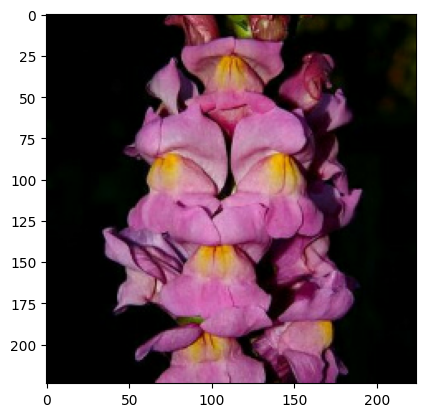

In [10]:
import random

import numpy as np


batch_imgs, batch_lbls = batch_train_tensors
batch_imgs_np = [(image.permute(1, 2, 0) * 255.0).numpy().astype(np.uint8) for image in batch_imgs]

rand_id = random.randrange(0, len(batch_imgs_np))
print(batch_lbls[rand_id])
plt.imshow(batch_imgs_np[rand_id])

In [11]:
xm.get_xla_supported_devices()

E0000 00:00:1724848342.709725      13 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:483


['xla:0', 'xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7']

In [13]:
device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
device

device(type='xla', index=0)

In [40]:
import math

import torch.nn as nn
from sklearn.metrics import f1_score
from tqdm import tqdm


class xml_fully_connected(nn.Module):
    def __init__(self, batch_size=(128, 3, 224, 224)) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(math.prod(batch_size[1:]), 1024),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 104),
        )

    def forward(self, batch):
        return self.model(batch.view(batch.shape[0], -1))

In [ ]:
from sklearn import metrics
from tqdm import tqdm


xml_model = xml_fully_connected(batch_train_tensors[0].shape).to(device)

num_epochs = 100
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(xml_model.parameters(), lr=5e-3)
batch_size = 1024

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    batch_generator = load_tensor_batches(
        load_dataset(get_recursive_paths(path, "train")), batch_size
    )
    for i, batch in enumerate(batch_generator):
        batch_img_tensor, batch_lbl_tensor = batch[0].to(device), batch[1].to(device)

        lbl_predict = xml_model(batch_img_tensor)
        output = loss(lbl_predict, batch_lbl_tensor)
        output.backward()
        opt.step()
        opt.zero_grad()

        print(f"Loss: {output.detach().cpu()}")

        predictions = torch.argmax(lbl_predict, dim=1).detach().cpu().numpy()
        f1 = metrics.f1_score(
            batch_lbl_tensor.detach().cpu().numpy(), predictions, average="macro"
        )
        print(f"F1-score: {f1}")

Epoch: 0
Loss: 4.639601230621338
F1-score: 0.004532550171316691
Loss: 776.4375610351562
F1-score: 0.0023285332900223788
Loss: 97.19160461425781
F1-score: 0.0023397550571463616
Loss: 22.9539794921875
F1-score: 0.0029190667246029806
Loss: 8.994812965393066
F1-score: 0.005036607923472347
Loss: 5.519814491271973
F1-score: 0.005627184725468822
Loss: 4.845381736755371
F1-score: 0.002375082871271051
Loss: 4.599767684936523
F1-score: 0.004810698248128445
Loss: 4.5916666984558105
F1-score: 0.007228338377476013
Loss: 4.577193260192871
F1-score: 0.008229014978337845
Loss: 4.468613147735596
F1-score: 0.008391971013496464
Loss: 4.4225754737854
F1-score: 0.004889254147107733
Epoch: 1
Loss: 4.437500476837158


In [ ]:
import os


try:
    os.environ.pop("CLOUD_TPU_TASK_ID")
except KeyError:
    print("already done")

try:
    os.environ.pop("TPU_PROCESS_ADDRESSES")
except KeyError:
    print("already done")

In [ ]:
import multiprocessing as mp

import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.experimental.pjrt as pjrt
import torch_xla.experimental.pjrt_backend  # Registers `pjrt://` init_method
from torch.nn.parallel import DistributedDataParallel as DDP

In [ ]:
lock = mp.Manager().Lock()


def print_device(i, lock):
    device = xm.xla_device()
    with lock:
        print("process", i, device)


xmp.spawn(print_device, args=(lock,), start_method="fork")

In [ ]:
def gather_ids(i, lock):
    # Create a tensor on each device with the device ID
    t = torch.tensor([i], device=xm.xla_device())
    with lock:
        print(i, t)

    # Collect and concatenate the IDs
    ts = xm.all_gather(t)
    xm.mark_step()
    with lock:
        print(i, ts)


xmp.spawn(gather_ids, args=(lock,), start_method="fork")

In [ ]:
def toy_model(index, lock):
    device = xm.xla_device()
    dist.init_process_group("xla", init_method="pjrt://")

    # Инициализация базовой модели
    torch.manual_seed(42)
    model = xml_fully_connected(batch_train_tensors[0].shape).to(
        device
    )  # Убедитесь, что xml_fully_connected определена

    # Распространение параметров от главного процесса
    pjrt.broadcast_master_param(model)

    print("hi")
    # `gradient_as_bucket_view=True` необходимо для XLA
    model = DDP(model, gradient_as_bucket_view=True)
    print("no")

    num_epochs = 100
    loss_fn = nn.CrossEntropyLoss()  # Переименовано для ясности
    opt = optim.Adam(model.parameters(), lr=5e-3)  # Исправлено на model вместо xml_model

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch}")
        for batch in load_tensor_batches(load_dataset(get_recursive_paths(path, "train"))):
            opt.zero_grad()

            batch_img_tensor, batch_lbl_tensor = batch[0].to(device), batch[1].to(device)

            lbl_predict = model(batch_img_tensor)  # Исправлено на model вместо xml_model
            output = loss_fn(lbl_predict, batch_lbl_tensor)
            output.backward()
            opt.step()
            # Запуск ожидающего графа
            xm.mark_step()

            with lock:
                # Печать средних значений параметров для подтверждения их одинаковости между репликами
                print(index, [p.mean() for p in model.parameters()])

In [ ]:
xmp.spawn(toy_model, args=(lock,), start_method="fork")